2025-10-16 15:44:41,667 - INFO - 处理二手房文件：.\hebei_esf_huailai_data.xlsx
2025-10-16 15:44:41,949 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：15.0 → 15.0万
2025-10-16 15:44:41,952 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：110.0 → 110.0万
2025-10-16 15:44:41,954 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：45.0 → 45.0万
2025-10-16 15:44:41,956 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：55.0 → 55.0万
2025-10-16 15:44:41,958 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：150.0 → 150.0万
2025-10-16 15:44:41,960 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：600.0 → 600.0万
2025-10-16 15:44:41,961 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：155.0 → 155.0万
2025-10-16 15:44:41,963 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：240.0 → 240.0万
2025-10-16 15:44:41,965 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：80.0 → 80.0万
2025-10-16 15:44:41,966 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：107.0 → 107.0万
2025-10-16 15:44:41,968 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：115.0 → 115.0万
2025-10-16 15:44:41,969 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：38.0 → 38.0万
2025-10-16 15:44:41,971 - INFO - 【特殊处理】怀来区域数据，强制按万单位处理，原值：190.0


=== 各街区租售比中位数（怀来、桥西修正后）===
    位置  租售比中位数
0  下花园  376.00
1   张北  323.33
2   怀来  524.58
3   桥西  446.51


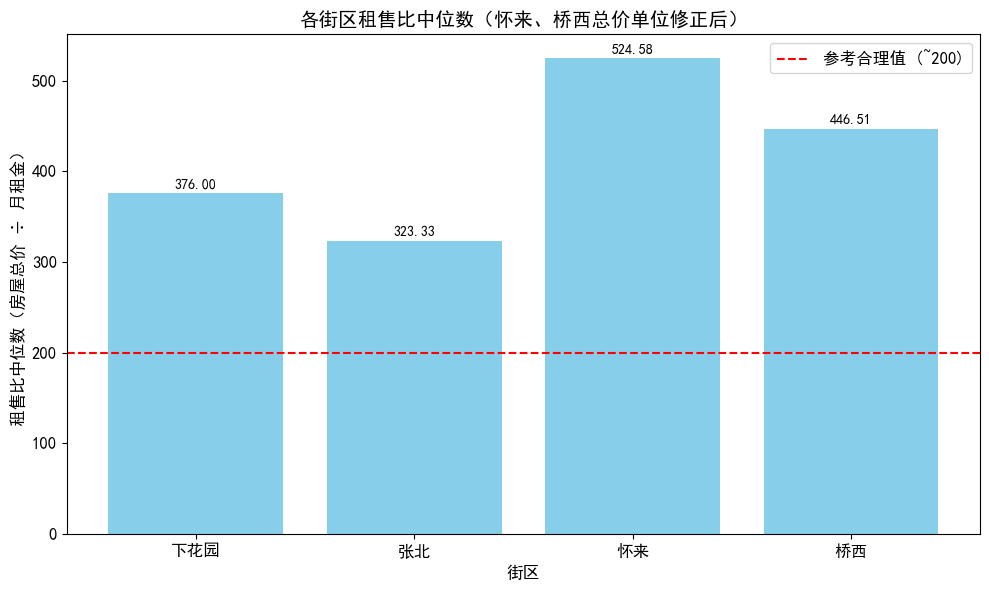

In [2]:
import pandas as pd
import re
import logging
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from datetime import datetime


# ====================== 1. 日志配置 ======================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"house_data_merge_{datetime.now().strftime('%Y%m%d')}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


# ====================== 2. 数据处理函数（仅修正怀来、桥西二手房总价单位） ======================
def process_second_hand_file(file_path: str) -> list[dict]:
    """处理二手房文件，修正怀来、桥西的总价单位（元→万）"""
    try:
        df = pd.read_excel(file_path)
        file_name = os.path.basename(file_path)
        area_match = re.search(r"esf_(.*?)_data", file_name)
        location = (
            area_match.group(1)
            .replace("huailai", "怀来")
            .replace("qiaoxi", "桥西")
            .replace("xiahuayuan", "下花园")
            .replace("zhangbei", "张北")
            if area_match
            else "未知区域"
        )

        results = []
        for idx, row in df.iterrows():
            # 提取面积
            area_str = str(row.get("面积", row.get("房屋面积", row.get("面积(㎡)", "")))).strip()
            area_num = re.search(r"(\d+(\.\d+)?)", area_str)
            area = float(area_num.group(1)) if area_num else None

            # 提取总价（核心：修正怀来、桥西的单位）
            total_price_str = str(row.get("总价", row.get("总价(万)", ""))).strip()
            price_match = re.search(r"(\d+(\.\d+)?)\s*([万千元]?)", total_price_str)
            total_price = None
            original_unit = ""
            if price_match:
                price_val = float(price_match.group(1))
                unit = price_match.group(3)
                original_unit = unit if unit else "元"
                
                # 仅对怀来、桥西的“元”单位强制转“万”（×10000）
                if location in ["怀来", "桥西"] and unit == "元":
                    logger.warning(f"【修正】{file_path} 第{idx+1}行，{location} 总价单位从'元'→'万'，原值：{total_price_str}")
                    total_price = price_val * 10000
                    original_unit = "万（修正后）"
                elif unit == "万":
                    total_price = price_val * 10000
                elif unit in ("元", ""):
                    total_price = price_val
                else:
                    logger.warning(f"{file_path} 第{idx+1}行：总价单位'{unit}'未识别，原值：{total_price_str}")
                    total_price = None

            # 计算单价并记录
            if area is not None and total_price is not None:
                unit_price = round(total_price / area, 2)
                results.append({
                    "位置": location,
                    "面积(㎡)": area,
                    "总价(元)": total_price,
                    "总价原始单位": original_unit,  # 记录原始/修正后单位
                    "单价(元/㎡)": unit_price
                })
        return results
    except Exception as e:
        logger.error(f"处理二手房文件 {file_path} 失败：{str(e)}")
        return []


def process_second_hand_file(file_path: str) -> list[dict]:
    """处理二手房文件，优化单位换算逻辑"""
    try:
        df = pd.read_excel(file_path)
        file_name = os.path.basename(file_path)
        area_match = re.search(r"esf_(.*?)_data", file_name)
        location = (
            area_match.group(1)
            .replace("huailai", "怀来")
            .replace("qiaoxi", "桥西")
            .replace("xiahuayuan", "下花园")
            .replace("zhangbei", "张北")
            if area_match
            else "未知区域"
        )

        results = []
        for idx, row in df.iterrows():
            # 提取面积
            area_str = str(row.get("面积", row.get("房屋面积", row.get("面积(㎡)", "")))).strip()
            area_num = re.search(r"(\d+(\.\d+)?)", area_str)
            area = float(area_num.group(1)) if area_num else None
            if area is None:
                logger.warning(f"{file_path} 第{idx+1}行：无法解析面积，原值：{area_str}")
                continue

            # 提取总价并优化单位判断逻辑
            total_price_str = str(row.get("总价", row.get("总价(万)", ""))).strip()
            
            # 更精确的单位检测逻辑
            unit = "元"  # 默认单位
            price_val = None
            
            # 情况1：明确包含"万"字
            if "万" in total_price_str:
                unit = "万"
                num_match = re.search(r"(\d+(\.\d+)?)\s*万", total_price_str)
                if num_match:
                    price_val = float(num_match.group(1))
            # 情况2：怀来、桥西特殊处理 - 直接按万单位处理
            elif location in ["怀来", "桥西"]:
                unit = "万"
                num_match = re.search(r"(\d+(\.\d+)?)", total_price_str)
                if num_match:
                    price_val = float(num_match.group(1))
                    logger.info(f"【特殊处理】{location}区域数据，强制按万单位处理，原值：{total_price_str} → {price_val}万")
            # 情况3：默认按元处理
            else:
                num_match = re.search(r"(\d+(\.\d+)?)", total_price_str)
                if num_match:
                    price_val = float(num_match.group(1))
            
            if price_val is None:
                logger.warning(f"{file_path} 第{idx+1}行：无法解析总价，原值：{total_price_str}")
                continue
            
            # 单位换算[1](@ref)
            if unit == "万":
                total_price = price_val * 10000
                original_unit = "万"
            else:  # 元
                total_price = price_val
                original_unit = "元"
            
            # 计算单价
            unit_price = round(total_price / area, 2)
            
            results.append({
                "位置": location,
                "面积(㎡)": area,
                "总价(元)": total_price,
                "总价原始单位": original_unit,
                "单价(元/㎡)": unit_price
            })
            
        return results
        
    except Exception as e:
        logger.error(f"处理二手房文件 {file_path} 失败：{str(e)}")
        return []


def process_rental_file(file_path: str) -> list[dict]:
    """处理租房文件，优化单位判断"""
    try:
        df = pd.read_excel(file_path)
        file_name = os.path.basename(file_path)
        area_match = re.search(r"zu_(.*?)_data", file_name)
        location = (
            area_match.group(1)
            .replace("huailai", "怀来")
            .replace("qiaoxi", "桥西")
            .replace("xiahuayuan", "下花园")
            .replace("zhangbei", "张北")
            if area_match
            else "未知区域"
        )

        results = []
        for idx, row in df.iterrows():
            # 提取面积
            area_str = str(row.get("面积", row.get("面积(㎡)", ""))).strip()
            area_num = re.search(r"(\d+(\.\d+)?)", area_str)
            area = float(area_num.group(1)) if area_num else None
            if area is None:
                logger.warning(f"{file_path} 第{idx+1}行：无法解析面积，原值：{area_str}")
                continue

            # 提取月租金
            rent_str = str(row.get("租金", row.get("月租金", row.get("租金(元/月)", "")))).strip()
            
            unit = "元"  # 默认单位
            rent_val = None
            
            # 更精确的单位检测
            if "万" in rent_str:
                unit = "万"
                num_match = re.search(r"(\d+(\.\d+)?)\s*万", rent_str)
                if num_match:
                    rent_val = float(num_match.group(1))
            elif "千" in rent_str:
                unit = "千"
                num_match = re.search(r"(\d+(\.\d+)?)\s*千", rent_str)
                if num_match:
                    rent_val = float(num_match.group(1))
            else:
                num_match = re.search(r"(\d+(\.\d+)?)", rent_str)
                if num_match:
                    rent_val = float(num_match.group(1))
            
            if rent_val is None:
                logger.warning(f"{file_path} 第{idx+1}行：无法解析租金，原值：{rent_str}")
                continue
            
            # 单位换算[1](@ref)
            if unit == "万":
                rent = rent_val * 10000
            elif unit == "千":
                rent = rent_val * 1000
            else:  # 元
                rent = rent_val
            
            # 计算单价
            unit_price = round(rent / area, 2)
            
            results.append({
                "位置": location,
                "面积(㎡)": area,
                "月租金(元)": rent,
                "租金原始单位": f"{unit}/月",
                "单价(元/月/㎡)": unit_price
            })
            
        return results
        
    except Exception as e:
        logger.error(f"处理租房文件 {file_path} 失败：{str(e)}")
        return []
# ====================== 3. 租售比计算（房屋总价 ÷ 月租金，参考线200） ======================
def calculate_price_to_rent_ratio(esf_df, zu_df):
    """计算各街区租售比中位数：房屋总价中位数 ÷ 月租金中位数（合理值≈200）"""
    esf_median = esf_df.groupby("位置")["总价(元)"].median().reset_index()
    esf_median.rename(columns={"总价(元)": "房屋总价中位数(元)"}, inplace=True)
    
    zu_median = zu_df.groupby("位置")["月租金(元)"].median().reset_index()
    zu_median.rename(columns={"月租金(元)": "月租金中位数(元)"}, inplace=True)
    
    ratio_df = pd.merge(esf_median, zu_median, on="位置", how="inner")
    ratio_df["租售比中位数"] = (ratio_df["房屋总价中位数(元)"] / ratio_df["月租金中位数(元)"]).round(2)
    return ratio_df


def plot_price_to_rent_ratio(ratio_df):
    """绘制租售比条形图（含参考线200）"""
    # 指定中文字体（Windows黑体）
    font_path = "C:/Windows/Fonts/simhei.ttf"
    chinese_font = FontProperties(fname=font_path, size=12)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(ratio_df["位置"], ratio_df["租售比中位数"], color='skyblue')
    
    # 参考线：全球合理值~200
    plt.axhline(y=200, color='r', linestyle='--', label='参考合理值 (~200)')
    
    # 图表样式
    plt.title('各街区租售比中位数（怀来、桥西总价单位修正后）', fontproperties=chinese_font, fontsize=14)
    plt.xlabel('街区', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('租售比中位数（房屋总价 ÷ 月租金）', fontproperties=chinese_font, fontsize=12)
    plt.legend(prop=chinese_font)
    plt.xticks(fontproperties=chinese_font)
    plt.yticks(fontproperties=chinese_font)
    
    # 标注数值
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.2f}', 
            ha='center', 
            fontsize=10,
            fontproperties=chinese_font
        )
    
    plt.tight_layout()
    plt.savefig('各街区租售比中位数（修正后）.png', dpi=300)
    plt.show()


# ====================== 4. 主流程 ======================
def main():
    data_dir = "."  # 数据文件所在目录
    all_second_hand = []
    all_rental = []

    # 遍历并合并数据
    for file_name in os.listdir(data_dir):
        if not file_name.endswith((".xlsx", ".xls")):
            continue
        file_path = os.path.join(data_dir, file_name)

        if "esf" in file_name:
            logger.info(f"处理二手房文件：{file_path}")
            all_second_hand.extend(process_second_hand_file(file_path))
        elif "zu" in file_name:
            logger.info(f"处理租房文件：{file_path}")
            all_rental.extend(process_rental_file(file_path))

    # 保存合并数据（含修正标记）
    if all_second_hand:
        df_esf = pd.DataFrame(all_second_hand)
        df_esf.to_excel("合并二手房数据（怀来桥西修正）.xlsx", index=False)
        logger.info(f"二手房数据合并完成，共 {len(df_esf)} 条")
    else:
        logger.warning("未提取到二手房数据")
        return

    if all_rental:
        df_zu = pd.DataFrame(all_rental)
        df_zu.to_excel("合并租房数据.xlsx", index=False)
        logger.info(f"租房数据合并完成，共 {len(df_zu)} 条")
    else:
        logger.warning("未提取到租房数据")
        return

    # 计算并可视化租售比
    ratio_df = calculate_price_to_rent_ratio(df_esf, df_zu)
    print("\n=== 各街区租售比中位数（怀来、桥西修正后）===")
    print(ratio_df[["位置", "租售比中位数"]])
    plot_price_to_rent_ratio(ratio_df)


if __name__ == "__main__":
    main()